# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [2]:
# загрузка данных
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# вывод 5 строк
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Информация о названии файла и возрасте человека на фото.

In [4]:
# вывод общей информации по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков нет в df.

In [5]:
# даные по распределению значений датасета
df.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


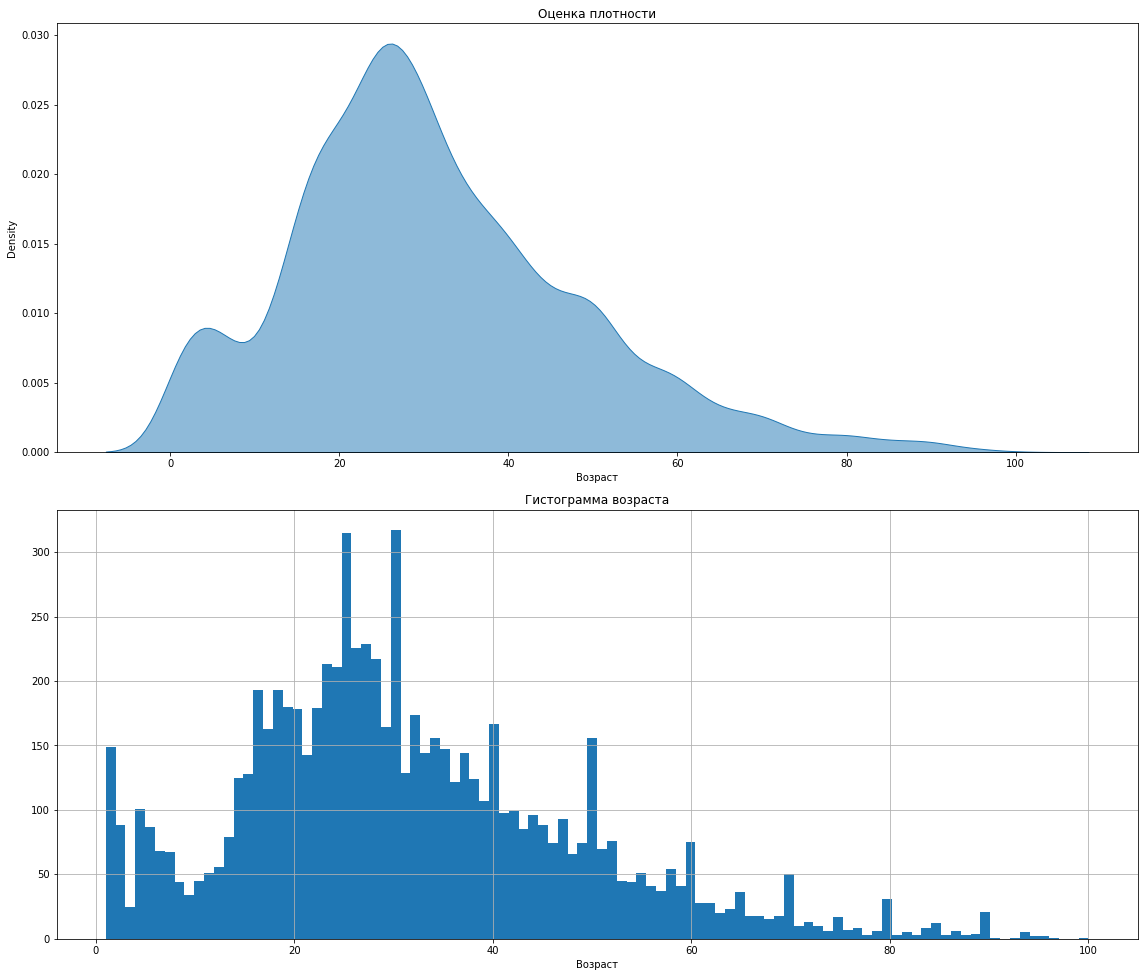

In [6]:
# графики плотности и гистограмма по возрастным группам
plt.figure(figsize=(16,20))
plt.subplot(311)
sns.kdeplot(data=df['real_age'], shade=True, 
                 alpha=.5, linewidth=1)
plt.xlabel("Возраст")
plt.title('Оценка плотности')

plt.subplot(312)
df['real_age'].hist(bins=100)

plt.xlabel("Возраст")
plt.title('Гистограмма возраста')

plt.tight_layout()

Распределение скошено вправо. Среднее значение больше медианы. Максимальный возраст - 100 лет: данная категория людей относится к долгожителям и не является часто встречающейся - это может сказаться на точности определения данной возрастной группы.
Длинный хвост наблюдается из объектов старше 60 лет. Почти на всех круглых возрастах наблюдаются пики (30, 40, 50, 60 лет и т.д.), либо есть ошибка ассесора, либо при сборе данных возраст не был указан точно, а был указан примерный. Вероятно, что данные на этих точках искажены, что может сказаться на качестве модели.

In [7]:
# данные по кол-ву записей, где возраст выше либо равен 90
df.query('real_age >= 90')['real_age'].value_counts().to_frame()

,real_age
90,21
94,5
95,2
96,2
91,1
93,1
97,1
100,1


Люди старше 90 лет встречается в сете редко. Высокая точность должна наблюдаться на образцах возрастом 20-41 год, на других возрастных группах - возможно увеличение ошибки. Метрику возьмем MAE.

Загрузим изображения. Использовать будем класс ImageDataGenerator.

In [8]:
# загрузка фото
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
                    dataframe=df, directory='/datasets/faces/final_files/',
                    x_col='file_name', 
                    y_col='real_age', 
                    target_size=(224, 224), 
                    batch_size=32, 
                    class_mode='raw', 
                    seed=12345
    )
features, target = next(train_gen_flow)

Found 7591 validated image filenames.


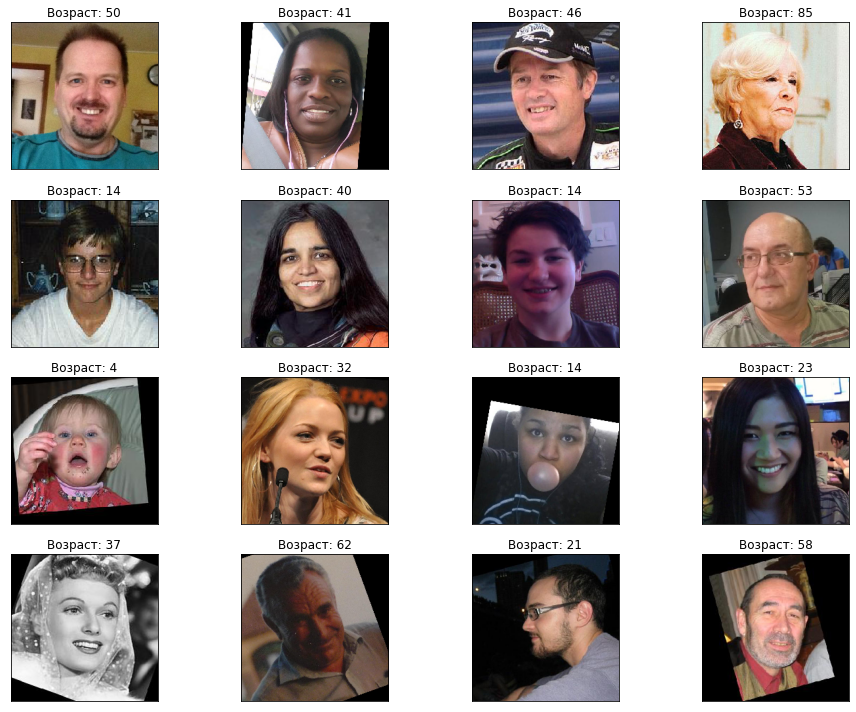

In [9]:
# вывод первых фото
fig = plt.figure(figsize=(15,10))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    
    plt.imshow(features[i])
    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Возраст: ' + str(target[i]))

### Вывод

Имеем фотографии людей различных возрастных групп. Фото разного качества, есть черно-белые и цветные фото, некоторые фото повернуты, используем незначительные изменения в виде горизонтального отображения. Показаны различные эмоции, у некоторых людей есть аксессуары. Использовать будем архитектуру сети на базе ResNet.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, разработанный Яндексом, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import numpy as np
import pandas as pd

def load_train(path):

    df = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       horizontal_flip=True,
                                       ,rescale=1/255.)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df, 
                                                            directory=path + '/final_files/',
                                                            x_col='file_name', 
                                                            y_col='real_age', 
                                                            target_size=(150, 150), 
                                                            batch_size=16, 
                                                            class_mode='raw',
                                                            subset='training', 
                                                            seed=12345)
    return train_datagen_flow

def load_test(path):

    df = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df, 
                                                         directory=path + '/final_files/',
                                                         x_col='file_name', 
                                                         y_col='real_age', 
                                                         target_size=(150, 150), 
                                                         batch_size=16, 
                                                         class_mode='raw',
                                                         subset='validation', 
                                                         seed=12345)
    return test_datagen_flow    

def create_model(input_shape):
 
    optimizer=Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)  
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 45s - loss: 223.5436 - mae: 10.9337 - val_loss: 900.6809 - val_mae: 25.1590
Epoch 2/10
356/356 - 36s - loss: 88.0336 - mae: 7.1672 - val_loss: 226.5559 - val_mae: 10.9627
Epoch 3/10
356/356 - 36s - loss: 61.2541 - mae: 5.9910 - val_loss: 98.9672 - val_mae: 7.4961
Epoch 4/10
356/356 - 36s - loss: 42.9782 - mae: 5.0406 - val_loss: 102.5238 - val_mae: 7.3875
Epoch 5/10
356/356 - 36s - loss: 33.0997 - mae: 4.3582 - val_loss: 100.5351 - val_mae: 7.3677
Epoch 6/10
356/356 - 36s - loss: 24.6892 - mae: 3.7840 - val_loss: 110.3622 - val_mae: 8.2041
Epoch 7/10
356/356 - 36s - loss: 19.3266 - mae: 3.3628 - val_loss: 77.2187 - val_mae: 6.4486
Epoch 8/10
Epoch 9/10
356/356 - 36s - loss: 15.8142 - mae: 3.0332 - val_loss: 69.6083 - val_mae: 6.2868
356/356 - 36s - loss: 13.8509 - mae: 2.8169 - val_loss: 68.5565 - val_mae: 6.1691
Epoch 10/10
356/356 - 36s - loss: 12.5617 - mae: 2.6900 - val_loss: 70.4001 - val_mae: 6.2440

119/119 - 9s - loss: 70.4001 - mae: 6.2440
Test MAE: 6.2440

```

## Анализ обученной модели

Построена модель, которая по фото определяет приблизительный возраст человека со средней ошибкой 6,24 года.  
Многослойные архитектуры сетей склонны к переобучению, но данный факт не может сигнализировать о плохом качестве модели, в данном случае, при необходимости, можно провести дополнительные тесты.  
Можно поэксперементировать с архитектурой сети, испытать другие варианты, если данный результат не устроит заказчика. Но по заданию требовалось: добиться значения MAE на тестовой выборке не больше 8.

Стояло две основные цели:
* анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* контролировать добросовестность кассиров при продаже алкоголя.

По первому пункту ошибка допустимая, по второму необходимо провести дополнительную проверку на возрастной группе до 18 лет.